<a href="https://colab.research.google.com/github/charlie-may86/Book-Model/blob/master/book_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to think about the problem:
Say I want to recommed only books which I think my users will rate as a 4 or 5?
- 4-5 can be true
- < 4 can be false  

I have created a classification problem. 

[Data source can be find here](https://www.kaggle.com/zygmunt/goodbooks-10k?select=ratings.csv)

In [40]:
import io
from google.colab import files
import pandas as pd
import numpy as np

In [41]:
#upload books df
upload = files.upload()

Saving books_unit2_project.csv to books_unit2_project (1).csv


In [42]:
#read in books df
books = pd.read_csv(io.BytesIO(upload['books_unit2_project.csv']), delimiter=',')

In [43]:
#upload ratings df
upload = files.upload()

Saving ratings_unit2_project.csv to ratings_unit2_project (1).csv


In [44]:
#read in ratings df
ratings = pd.read_csv(io.BytesIO(upload['ratings_unit2_project.csv']), delimiter=',')

In [45]:
#create a df that contains user_id and their mean rating
average_ratings = pd.DataFrame(ratings.groupby('user_id')['rating'].mean())

#rename the column in average_ratings so it can be added as a separte column back to ratings
average_ratings.rename(columns={"rating": "average_user_rating"}, inplace=True)
average_ratings

#merge ratings and average_ratings to add in a users average rating
ratings_merged = ratings.merge(average_ratings, left_on='user_id', right_on='user_id')


In [46]:
#check
ratings_merged.head()

,book_id,user_id,rating,average_user_rating
0,1,314,5,3.585635
1,3,314,3,3.585635
2,5,314,4,3.585635
3,6,314,5,3.585635
4,12,314,4,3.585635


In [47]:
#merge ratings df and books df 
df_merged = ratings_merged.merge(books, left_on='book_id', right_on='book_id')
df_merged.head()

,book_id,user_id,rating,average_user_rating,id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,314,5,3.585635,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
1,1,439,3,3.259887,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
2,1,588,5,3.618280,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
3,1,1169,4,3.770053,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
4,1,1185,4,3.473684,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...


In [48]:
df_merged.shape

(79701, 26)

In [49]:
#drop the columns I know I will never need
df_merged = df_merged.drop(['authors', 'original_title', 'title', 'image_url',
                            'isbn', 'isbn13', 'small_image_url'], axis = 1)

In [50]:
df_merged.shape

(79701, 19)

In [51]:
#check
df_merged.head()

,book_id,user_id,rating,average_user_rating,id,best_book_id,work_id,books_count,original_publication_year,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,1,314,5,3.585635,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
1,1,439,3,3.259887,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
2,1,588,5,3.618280,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
3,1,1169,4,3.770053,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
4,1,1185,4,3.473684,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491


In [52]:
#split into a two dfs 
#train_val will be split again for training and validation
#test will be held out for testing

from sklearn.model_selection import train_test_split

train_val, test = train_test_split(df_merged, train_size=0.85, test_size=0.15,
                              stratify=df_merged['average_rating'], random_state=42)


In [53]:
#split train_val into a train and test set
train, val = train_test_split(train_val, train_size=0.85, test_size=0.15,
                              stratify=train_val['average_rating'], random_state=42)

In [54]:
def wrangle(X):
  
  #Prevent SettingWithCopyWarning
  X = X.copy()

  #create a new bool column which represents a 5 star rating
  X['read_next'] = np.where(X['rating'] == 5, True, False)

  #convert original_publication_year to a data
  X['original_publication_year'] = pd.to_datetime(X['original_publication_year'], infer_datetime_format=True)
  
  #Pull year out 
  X['year_published'] = X['original_publication_year'].dt.year
  X = X.drop(columns='original_publication_year')

  #the model can be too picky, and simply never picks 5 stars - dropping columns may help
  # X = X.drop(columns=['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5'])

  #5 star percentage
  X['5_star_percentage'] = X['ratings_5'] / (X['ratings_1'] + X['ratings_2'] + X['ratings_3'] +
                                             X['ratings_4'] + X['ratings_5'])
  


  return(X)

In [55]:
train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

In [56]:
train_wrangled['read_next'].value_counts(normalize=True)

False    0.698852
True     0.301148
Name: read_next, dtype: float64

In [57]:
train_wrangled.head()

,book_id,user_id,rating,average_user_rating,id,best_book_id,work_id,books_count,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,read_next,year_published,5_star_percentage
35171,9822,39176,5,4.720000,738,9822,839692,73,NaN,4.13,135978,142350,2718,1620,4727,26279,50968,58756,True,1970.0,0.412757
52974,8953,33962,1,3.714286,2961,8953,2049173,43,eng,3.98,34587,35493,3302,820,2063,7351,11982,13277,False,1970.0,0.374074
55553,6150,17920,5,3.312500,2190,6150,59082,123,eng,3.87,47389,53681,3213,1524,3969,11995,18837,17356,True,1970.0,0.323317
31639,1519,28459,5,3.369863,4149,1519,2378,255,eng,3.99,24588,28162,705,323,1471,6415,9813,10140,True,1969.0,0.360060
40648,3412,24966,4,3.600000,311,3412,816449,201,eng,4.22,255651,266826,4556,2889,9117,42299,85531,126990,False,1970.0,0.475928


In [72]:
import plotly.express as px
fig = px.bar(train_wrangled, x='book_id', y='average_rating')
fig.show()

In [58]:
# The fv_time_total_production column is the target
target = 'read_next'

# Get a dataframe with all train columns except the target
train_features = train_wrangled.drop(columns=[target, 'rating'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [59]:
X_train = train_wrangled[features]
y_train = train_wrangled[target]
X_val = val_wrangled[features]
y_val = val_wrangled[target]
X_test = test_wrangled[features]
y_test = test_wrangled[target]

In [60]:
X_train.head()

,book_id,user_id,average_user_rating,id,best_book_id,work_id,books_count,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,year_published,5_star_percentage,language_code
35171,9822,39176,4.720000,738,9822,839692,73,4.13,135978,142350,2718,1620,4727,26279,50968,58756,1970.0,0.412757,NaN
52974,8953,33962,3.714286,2961,8953,2049173,43,3.98,34587,35493,3302,820,2063,7351,11982,13277,1970.0,0.374074,eng
55553,6150,17920,3.312500,2190,6150,59082,123,3.87,47389,53681,3213,1524,3969,11995,18837,17356,1970.0,0.323317,eng
31639,1519,28459,3.369863,4149,1519,2378,255,3.99,24588,28162,705,323,1471,6415,9813,10140,1969.0,0.360060,eng
40648,3412,24966,3.600000,311,3412,816449,201,4.22,255651,266826,4556,2889,9117,42299,85531,126990,1970.0,0.475928,eng


In [ ]:
import plotly.express as px
fig = px.bar(X_train, x="sex", y="total_bill", color="smoker", barmode="group")
fig.show()

In [61]:
X_train.shape

(57583, 19)

In [ ]:
!pip install category_encoders==2.*
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
!pip from sklearn.feature_selection import f_regression, SelectKbest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
import category_encoders as ce 

In [ ]:
# do a kmeans clustering based on users and ratings

#add a range function

In [24]:
pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
)    

param_distributions = {     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__min_samples_split': range(1, 15),
    'randomforestclassifier__min_samples_leaf': range(1, 20),
    'randomforestclassifier__max_depth': range(3, 20), 
    'randomforestclassifier__max_features': uniform(0, 2)
   
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=30, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 36.3min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 43

In [25]:
#hyperparameters and score
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 13, 'randomforestclassifier__max_features': 0.2978042480039582, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__min_samples_split': 6, 'randomforestclassifier__n_estimators': 78, 'simpleimputer__strategy': 'mean'}
Cross-validation accuracy 0.7815326923731725


In [62]:
pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(criterion='entropy', max_depth=13,
                           max_features=0.2978042480039582, min_samples_leaf=3,
                           min_samples_split=6, n_estimators=78)
)  

In [63]:
pipeline.fit(X_val, y_val)
print(f'Accuracy: {pipeline.score(X_val, y_val)}')

Accuracy: 0.8404841566620744


In [64]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy:,.6f}')

Test accuracy: 0.777852


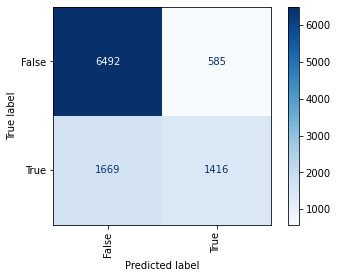

In [65]:
#Check the results
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(search, X_val, y_val,
                      values_format='.0f', xticks_rotation='vertical', cmap="Blues")

In [ ]:
#what is a persons average rating
#what if I only wanted 5 star books
#it is probably more interesting to do only 5 star books

In [ ]:
# What is the average rating for True recommendations that were actually false? 
#Presumably that is something I can find out. 

In [34]:
from joblib import dump
dump(pipeline, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [36]:
!ls -1h pipeline.joblib

pipeline.joblib


In [37]:
from google.colab import files
files.download('pipeline.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
import joblib
import sklearn
import category_encoders as ce


print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
# print(f'pipeline=={make_pipeline.__version__}')

joblib==0.15.1
scikit-learn==0.22.2.post1
category_encoders==2.2.2


In [38]:
def predict(user_id, book_id):
  df = pd.DataFrame(
      columns=['user_id', 'book_id'],
      data = [[user_id, book_id]]
  )
  y_pred = pipeline.predict(df)
  return y_pred

y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy:,.6f}')


Test accuracy: 0.775761


Results after deleting all the star ratings: 
- True / True = 1406
- Cross-validation accuracy 0.7791362111679936

Results with all the star ratings:
- n_iter=30 
- cv=5 
- True(true) / True(false) = 1420 / 1665

Results after deleting star ratings: 
- n_iter=30 
- cv=5 
- True(true) / True(false) = 1419 / 1666
- False(true) = 568

Results: 
- Model contained all catigories of rating
- n_iter=30 
- cv=5 
- True(true) / True(false) = 1428 / 1657
- False(true) = 571
- Cross-validation accuracy 0.7818974460726661
